In [1]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42

2023-01-08 06:02:56.625771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 06:02:56.750868: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-08 06:02:56.750900: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-08 06:02:57.319807: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Specify each path

In [2]:
import tensorflow

In [3]:
dataset = 'keypoint.csv'#'model/keypoint_classifier/keypoint.csv'
model_save_path = 'keypoint_classifier.hdf5'#'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'keypoint_classifier.tflite'#'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes and sort data

In [4]:
NUM_CLASSES = 4

pd.read_csv('keypoint.csv', header=None).sort_values(0).to_csv('keypoint.csv', index=False, header=None)

# Dataset reading

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

2023-01-08 06:02:59.068551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 06:02:59.069055: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-08 06:02:59.069118: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-08 06:02:59.069159: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-08 06:02:59.069199: W tensorflow/c

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1,114
Trainable params: 1,114
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/9 [==>...........................] - ETA: 5s - loss: 1.4962 - accuracy: 0.2578
Epoch 1: saving model to keypoint_classifier.hdf5
9/9 [==============================] - 1s 29ms/step - loss: 1.4668 - accuracy: 0.2361 - val_loss: 1.4185 - val_accuracy: 0.2808
Epoch 2/1000
1/9 [==>...........................] - ETA: 0s - loss: 1.3823 - accuracy: 0.2656
Epoch 2: saving model to keypoint_classifier.hdf5
9/9 [==============================] - 0s 7ms/step - loss: 1.4166 - accuracy: 0.2514 - val_loss: 1.3619 - val_accuracy: 0.2808
Epoch 3/1000
1/9 [==>...........................] - ETA: 0s - loss: 1.3764 - accuracy: 0.2891
Epoch 3: saving model to keypoint_classifier.hdf5
9/9 [==============================] - 0s 9ms/step - loss: 1.3598 - accuracy: 0.3394 - val_loss: 1.2849 - val_accuracy: 0.4785
Epoch 4/1000
1/9 [==>...........................] - ETA: 0s - loss: 1.3877 - accuracy: 0.2344
Epoch 4: saving model to keypoint_classifier.hdf5
9/9 [==============================] - 0s 

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 [==============================] - 0s 2ms/step - loss: 0.0465 - accuracy: 1.0000


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 57ms/step
[4.8363366e-04 7.6008943e-04 2.0522885e-02 9.7823346e-01]
3


# Confusion matrix

11/11 [==============================] - 0s 905us/step


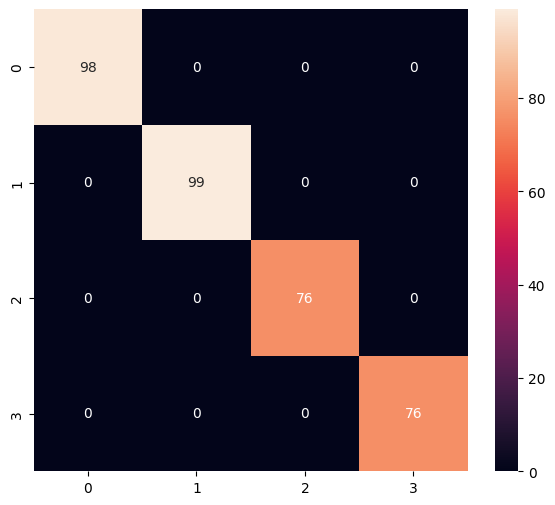

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00        76
           3       1.00      1.00      1.00        76

    accuracy                           1.00       349
   macro avg       1.00      1.00      1.00       349
weighted avg       1.00      1.00      1.00       349



In [16]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp9fde2owk/assets


INFO:tensorflow:Assets written to: /tmp/tmp9fde2owk/assets
2023-01-08 06:03:14.541014: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-08 06:03:14.541048: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-01-08 06:03:14.541563: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9fde2owk
2023-01-08 06:03:14.542824: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-01-08 06:03:14.542839: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9fde2owk
2023-01-08 06:03:14.547668: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-01-08 06:03:14.548554: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-01-08 06:03:14.578692: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

6544

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 548 µs, sys: 98 µs, total: 646 µs
Wall time: 435 µs


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.8363386e-04 7.6009013e-04 2.0522878e-02 9.7823346e-01]
3
